Silly little script to plot gradient and segmented reference curves

#50=IfcCompositeCurve((#29),.F.)
#107=IfcGradientCurve((#58,#66,#74,#82,#90,#98,#106),.F.,#50,$)
[[ 0.99503719  0.          0.09950372 30.        ]
 [ 0.          1.          0.          0.        ]
 [-0.09950372  0.          0.99503719 -3.        ]
 [ 0.          0.          0.          1.        ]]


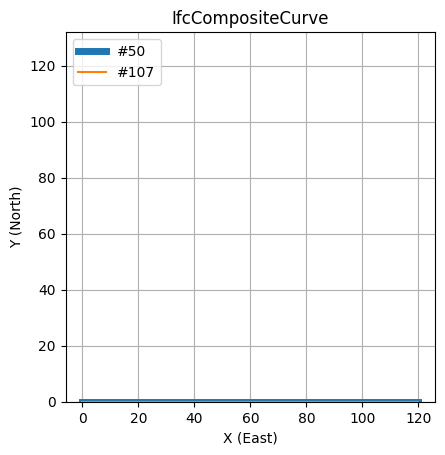

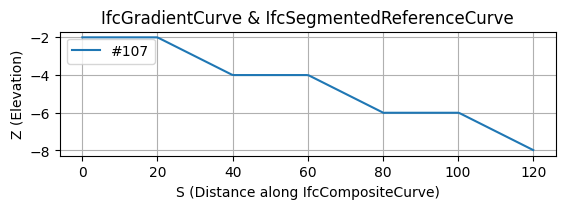

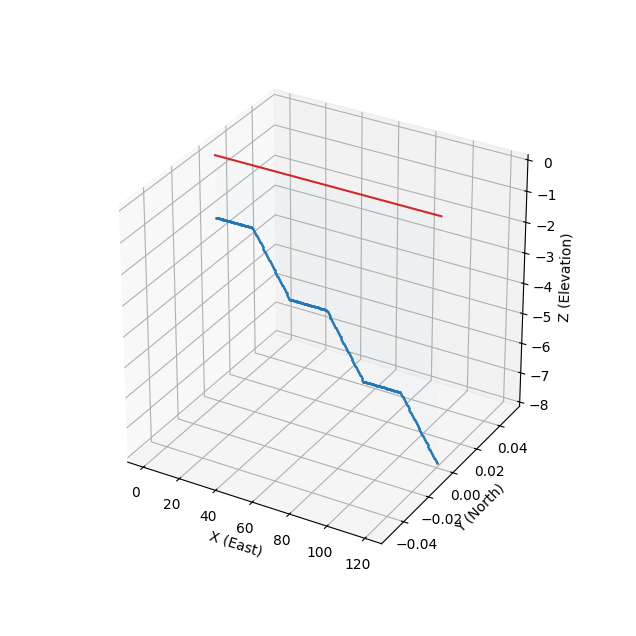

In [2]:
import ifcopenshell
import ifcopenshell.geom as geom
import numpy as np
import matplotlib.pyplot as plt
import math

#model = ifcopenshell.open("F:/IfcOpenShell/_build-vs2022-x64/examples/FHWA_Bridge_Geometry_Alignment_Example.ifc")
#model = ifcopenshell.open("F:/IfcAlignmentDriver/TestFiles/00_LRT_BIM-Station_Platform edge_dummyNB.ifc")
#model = ifcopenshell.open("F:/IfcAlignmentDriver/TestFiles/241017.alignment.revised.ifc")
#model = ifcopenshell.open("F:/IfcAlignmentDriver/TestFiles/github_issue_5502_example_5.ifc")
model = ifcopenshell.open("F:/IfcAlignmentDriver/TestFiles/github_issue_5502_example_5_us.ifc")

settings = geom.settings()

fig1 = plt.figure().add_subplot()
fig2 = plt.figure().add_subplot()
fig3 = plt.figure(figsize=(8,8)).add_subplot(projection="3d")

hcurves = model.by_type("IfcCompositeCurve",False)
for hc in hcurves:
    print(hc)
    shape = geom.create_shape(settings,hc)
    verts = shape.verts
    verts = np.array(verts).reshape((-1,3))
    x,y,z = verts.T
    fig1.plot(x,y,linewidth=5,label="#" + str(hc.id()))
    



curves = model.by_type("IfcGradientCurve",False) + model.by_type("IfcSegmentedReferenceCurve",False)
for curve in curves:
    print(curve)
    pwf = ifcopenshell.ifcopenshell_wrapper.map_shape(settings,curve.wrapped_data)
    evaluator = ifcopenshell.ifcopenshell_wrapper.piecewise_function_evaluator(pwf)
    distances = evaluator.evaluation_points()
    #distances = pwf.evaluation_points()
    
    shape = geom.create_shape(settings,curve)
    verts = shape.verts
    verts = np.array(verts).reshape((-1,3))
    x,y,z = verts.T
    #print(verts)
    
    fig1.plot(x,y,label="#" + str(curve.id()))
    fig2.plot(distances,z,label="#" + str(curve.id()))
    
    markerline, stemline, baseline = fig3.stem(x,y,z)
    plt.setp(stemline,linewidth=0.01)
    plt.setp(stemline,linestyles="dashed")
    plt.setp(markerline,markersize=1)

    #print(np.array(evaluator.evaluate(20.0)))
    print(np.array(evaluator.evaluate(30.0)))
    #print(np.array(evaluator.evaluate(40.0)))

    # plot left and right edges based on a fake offset value. this will show if the y axis vector is correct
    offset = 10.0
    left = []
    right = []
    for u in distances:
        m = evaluator.evaluate(u)
        z = np.array(m)[:,3][2] # get the curve elevation
        y = np.array(m)[:,1] # get the Y vector

        dx = y[0]
        dy = y[1]
        dz = y[2]

        sign = 1.0
        if dy != 0.0:
           sign = dy/math.fabs(dy)
                
        ds = sign * math.sqrt(dx*dx+dz*dz) # magnitude of vector in cross-section plane
        left.append(-0.5*offset*dz/dy + z)
        right.append(0.5*offset*dz/dy + z)

    #fig2.plot(distances,left,label="Left")
    #fig2.plot(distances,right,label="Right")


fig1.set_title("IfcCompositeCurve")
fig1.legend(loc="upper left")
fig1.axis("square")
fig1.set_aspect('equal',adjustable='box')
fig1.set_xlabel("X (East)")
fig1.set_ylabel("Y (North)")
fig1.grid(True)

fig2.set_title("IfcGradientCurve & IfcSegmentedReferenceCurve")
fig2.legend(loc="upper left")
fig2.set_xlabel("S (Distance along IfcCompositeCurve)")
fig2.set_ylabel("Z (Elevation)")
fig2.set_box_aspect(0.25)
fig2.grid(True)

#fig3.set_title("IfcGradientCurve")
#fig3.legend()
#fig3.axis("square")
fig3.set_xlabel("X (East)")
fig3.set_ylabel("Y (North)")
fig3.set_zlabel("Z (Elevation)")
fig3.grid(True)
fig3.set_box_aspect([1,1,1],zoom=0.8)
#fig3.set_box_aspect(aspect=None,zoom=0.8)

#plt.savefig("Alignment.png")
plt.show()
